In [1]:
import time
import os

from lib.event_tweet_parser import EventTweetParser
from lib.util import load_file, fix_json_file

def pheme_to_csv(event_name, output_dir="data/tweets"):
    start_time = time.time()
    parser = EventTweetParser(event_name, output_dir=output_dir)
    base_path = "pheme-raw/threads/en"
    thread_count = 0

    for thread_id in os.listdir(f"{base_path}/{event_name}"):
        thread_count += 1

        for source_tweet_file in os.listdir(f"{base_path}/{event_name}/{thread_id}/source-tweets"):
            source_tweet = load_file(f"{base_path}/{event_name}/{thread_id}/source-tweets/{source_tweet_file}")
            parser.append(source_tweet, thread_id)

        for reaction_file in os.listdir(f"{base_path}/{event_name}/{thread_id}/reactions"):
            reaction_tweet = load_file(f"{base_path}/{event_name}/{thread_id}/reactions/{reaction_file}")
            parser.append(reaction_tweet, thread_id)

        retweets_file_path = f"{base_path}/{event_name}/{thread_id}/retweets.json"
        if os.path.exists(retweets_file_path):
            # fix_json_file(retweets_file_path)
            retweets = load_file(retweets_file_path)
            for retweet in retweets:
                parser.append(retweet, thread_id)

    output_file_path = parser.export()
    print(f"{thread_count} threads were processed for {event_name}")
    print(f"{output_file_path} was generated in {(time.time() - start_time) / 60} minutes")
    
    return None

parser = pheme_to_csv("ebola-essien")
# parser.print_data_info()

Number of annotations: 4560
2 threads were processed for ebola-essien
data/tweets/ebola-essien.csv was generated in 0.012066201368967692 minutes


In [1]:
from lib.event_tweets import EventTweets

event = "ebola-essien"
event_tweets = EventTweets(event)
tweets_df = event_tweets.get_tweets()

In [2]:
# Filter the DataFrame to get tweets with in_reply_to_user_id or in_reply_to_status_id equal to 0
filtered_tweets_df = tweets_df[(tweets_df['in_reply_to_user_id'] == 0) | (tweets_df['in_reply_to_status_id'] == 0)]
selected_columns_df = filtered_tweets_df[['class', 'in_reply_to_user_id', 'in_reply_to_status_id']]
print(selected_columns_df)

       class  in_reply_to_user_id  in_reply_to_status_id
0     source                    0                      0
27   retweet                    0                      0
28   retweet                    0                      0
29   retweet                    0                      0
30   retweet                    0                      0
..       ...                  ...                    ...
203  retweet                    0                      0
204  retweet                    0                      0
205  retweet                    0                      0
206  retweet                    0                      0
207   source                    0                      0

[182 rows x 3 columns]


In [4]:
# Double check null data!
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweet_id                  216 non-null    int64 
 1   thread_id                 216 non-null    int64 
 2   class                     216 non-null    object
 3   in_reply_to_status_id     216 non-null    int64 
 4   in_reply_to_user_id       216 non-null    int64 
 5   support                   2 non-null      object
 6   responsetype_vs_source    32 non-null     object
 7   responsetype_vs_previous  10 non-null     object
 8   favorite_count            216 non-null    int64 
 9   retweet_count             216 non-null    int64 
 10  favorited                 216 non-null    bool  
 11  user_id                   216 non-null    int64 
 12  created_at                216 non-null    object
 13  place                     2 non-null      object
dtypes: bool(1), int64(7), obje

In [5]:
tweets_df.head()

,tweet_id,thread_id,class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,favorited,user_id,created_at,place
0,521346721226711040,521346721226711040,source,0,0,supporting,NaN,NaN,85,575,False,579635019,Sun Oct 12 17:08:39 +0000 2014,NaN
1,521349366037356544,521346721226711040,direct reply,521346721226711040,579635019,NaN,appeal-for-more-information,NaN,5,1,False,463260500,Sun Oct 12 17:19:09 +0000 2014,NaN
2,521349434719076352,521346721226711040,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,1,False,430026970,Sun Oct 12 17:19:26 +0000 2014,NaN
3,521350130851921921,521346721226711040,direct reply,521346721226711040,579635019,NaN,comment,NaN,0,0,False,379856833,Sun Oct 12 17:22:12 +0000 2014,"{'full_name': 'Brasília, Distrito Federal', 'u..."
4,521350466647891968,521346721226711040,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,0,False,458672503,Sun Oct 12 17:23:32 +0000 2014,NaN


In [6]:
import networkx as nx

G = nx.DiGraph()

for _, tweet in tweets_df.iterrows():
    tweet_id = tweet['tweet_id']
    thread_id = tweet['thread_id']
    tweet_class = tweet['class']
    in_reply_to_status_id = tweet['in_reply_to_status_id']
    user_id = tweet['user_id']
    
    # Add the tweet as a node with user_id as an attribute
    G.add_node(tweet_id, user_id=user_id, tweet_class=tweet_class)
    
    # Egde represents a reply or retweet directed from the source tweet
    if tweet_class == 'direct reply' or tweet_class == 'retweet':
        G.add_edge(thread_id, tweet_id)
    elif tweet_class == 'deep reply':
        G.add_edge(in_reply_to_status_id, tweet_id)

In [7]:
# Find the node with the most edges
node_with_most_edges = max(G.degree, key=lambda x: x[1])
print(f"Node with the most edges: {node_with_most_edges[0]}, Number of edges: {node_with_most_edges[1]}")

Node with the most edges: 521346721226711040, Number of edges: 197


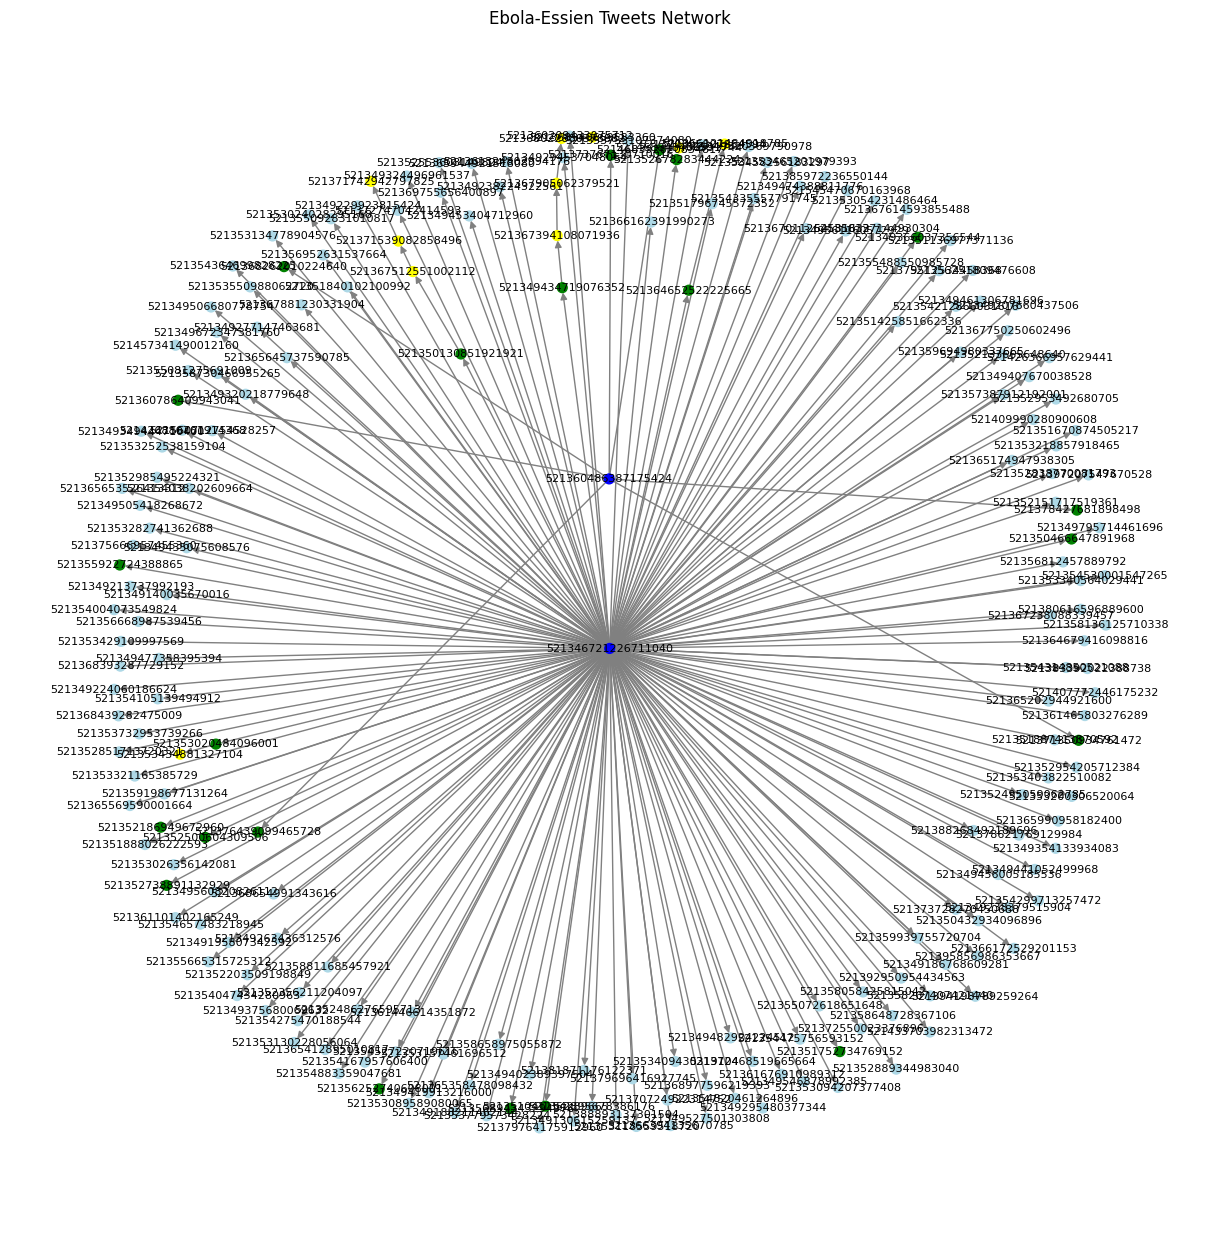

In [8]:
import matplotlib.pyplot as plt

# Define colors for different types of tweets
source_color = 'blue'
direct_reply_color = 'green'
retweet_color = 'lightblue'
deep_reply_color = 'yellow'

# Create a color map for the nodes based on tweet types
node_colors = []
for node in G.nodes():
    tweet_class = G.nodes[node].get('tweet_class', 'unknown')
    if tweet_class == 'source':
        node_colors.append(source_color)
    elif tweet_class == 'direct reply':
        node_colors.append(direct_reply_color)
    elif tweet_class == 'retweet':
        node_colors.append(retweet_color)
    elif tweet_class == 'deep reply':
        node_colors.append(deep_reply_color)
    else:
        node_colors.append('gray')  # Default color for unknown types

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, node_color=node_colors, font_size=8, font_color="black", edge_color="gray")
plt.title("Ebola-Essien Tweets Network")
plt.show()